In [1]:
import os
import re
from lib_log_parse import load_parsed_logs, parse
from typing import Dict, List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from typing import Tuple

sns.set_theme()

In [2]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [3]:
path = "../data/2022-11-28_hydra_dial_down"

In [10]:
values = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    if os.path.exists(file_path + ".p"):
        print(f"Skipping: {file_path}")
        continue

    values += [[file_path]]

with mp.Pool() as pool:
    pool.map(parse, values)

Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-1-node-5.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-1-node-4.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-1-node-6.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-1-node-3.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-1-node-2.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-1-node-0.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-1-node-1.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-2-node-2.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-2-node-3.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-2-node-1.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-2-node-0.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-2-node-4.log
Skipping: ../data/2022-11-28_hydra_dial_down/nodes-list-fleet-2-node-5.log
Parsing ../data/2022-11-2

In [11]:
files = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    files += [file_path]
pool = mp.Pool(mp.cpu_count())
results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))

In [12]:
results[0][0].retrievals[0].origin

'../data/2022-11-28_hydra_dial_down/nodes-list-fleet-1-node-5.log'

In [29]:
def log_origin(origin: str) -> Optional[Tuple[int, int]]:
    match = re.search(r".*\/nodes-list-fleet-(\d)-node-(\d).log", origin)
    if match is None:
        return None

    fleet = int(match.group(1))
    node = int(match.group(2))
    return fleet, node


def map_region(fleet: int, node: int) -> str:
    if fleet == 1:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
    elif fleet == 2:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_us_ash"
    raise Exception(f"unknown fleet {fleet} node {node} combination")


def region_from_origin(origin: str) -> str:
    fleet, node = log_origin(origin)
    return map_region(fleet, node)


results_by_region = {}

for idx, f in enumerate(files):
    region = region_from_origin(f)

    if not region in results_by_region:
        results_by_region[region] = []
    results_by_region[region] += [results[idx][0]]

In [30]:
results_by_region

{'sa_east_1': [<lib_log_parse.ParsedLogFile at 0x162dec5e0>,
 'eu_central_1': [<lib_log_parse.ParsedLogFile at 0x2bc8152d0>,
 'hetzner_eu_nbg': [<lib_log_parse.ParsedLogFile at 0x2c0503b20>],
 'us_west_1': [<lib_log_parse.ParsedLogFile at 0x32daf7940>,
 'af_south_1': [<lib_log_parse.ParsedLogFile at 0x2ca7a1990>,
 'me_south_1': [<lib_log_parse.ParsedLogFile at 0x3a00ed1e0>,
 'ap_southeast_2': [<lib_log_parse.ParsedLogFile at 0x323e75660>,
 'hetzner_us_ash': [<lib_log_parse.ParsedLogFile at 0x3ce8ece80>]}

In [31]:
publications: List[Publication] = []
retrievals: List[Retrieval] = []
for parsed_log in results:
    for log in parsed_log:
        publications += log.publications
        retrievals += log.retrievals

# Remove all retrievals that are marked as invalid
retrievals = list(
    filter(lambda ret: not ret.marked_as_incomplete, retrievals))
retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

overall_retrieval_duration_per_region: Dict[str, List[float]] = {}
dht_ret_walks_duration_per_region: Dict[str, List[float]] = {}
dht_ret_find_first_provider_per_region: Dict[str, List[float]] = {}
content_fetch_duration_per_region: Dict[str, List[float]] = {}
retrieval_find_provider_queries_per_region: Dict[str, List[float]] = {}
retrieval_errors_per_region: Dict[str, int] = {}

for ret in retrievals:
    region = region_from_origin(ret.origin)
    if region is None:
        raise Exception("AHH")

    if ret.stream_opened_at is None or ret.connected_at is None:
        print("skip", ret.stream_opened_at, ret.connected_at)
        continue

    if ret.done_retrieving_error is not None:
        print(f"{ret.cid} in {ret.origin} had error: {ret.done_retrieving_error}")
        if region not in retrieval_errors_per_region:
            retrieval_errors_per_region[region] = 0
        retrieval_errors_per_region[region] += 1

    overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
    # simulate peer record retrieval by adding the DHT walk duration
    overall_retrieval_duration += ret.get_dht_walk_duration()
    if region not in overall_retrieval_duration_per_region:
        overall_retrieval_duration_per_region[region] = []
    overall_retrieval_duration_per_region[region] += [overall_retrieval_duration]

    # simulate peer record retrieval by adding the DHT walk duration
    dht_walk_duration = 2 * ret.get_dht_walk_duration()
    if region not in dht_ret_walks_duration_per_region:
        dht_ret_walks_duration_per_region[region] = []
    dht_ret_walks_duration_per_region[region] += [dht_walk_duration]

    dht_ret_find_first_provider = (
            ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()
    if region not in dht_ret_find_first_provider_per_region:
        dht_ret_find_first_provider_per_region[region] = []
    dht_ret_find_first_provider_per_region[region] += [dht_ret_find_first_provider]

    content_fetch_duration = (ret.done_retrieving_at - ret.dial_started_at).total_seconds()
    if region not in content_fetch_duration_per_region:
        content_fetch_duration_per_region[region] = []
    content_fetch_duration_per_region[region] += [content_fetch_duration]

    if region not in retrieval_find_provider_queries_per_region:
        retrieval_find_provider_queries_per_region[region] = []

    retrieval_find_provider_queries_per_region[region] += [
        len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))
    ]


skip None 2022-11-26 01:27:56.673828+00:00
skip None 2022-11-26 03:13:57.461092+00:00
skip None 2022-11-27 09:26:22.142936+00:00
skip None 2022-11-28 03:40:53.378387+00:00
skip None 2022-11-28 03:51:49.151898+00:00
skip None 2022-11-26 13:08:16.063403+00:00
skip None 2022-11-26 16:13:45.958209+00:00
skip None 2022-11-26 19:48:54.547618+00:00
skip None 2022-11-26 20:33:48.770438+00:00
skip None 2022-11-27 08:41:53.912341+00:00
skip None 2022-11-26 20:33:48.931369+00:00
skip None 2022-11-27 08:41:54.222476+00:00
skip None 2022-11-27 12:01:38.543387+00:00
skip None 2022-11-26 02:12:45.173559+00:00
skip None 2022-11-26 23:39:02.658938+00:00
skip None 2022-11-26 17:58:42.174780+00:00
skip None 2022-11-28 10:53:45.966552+00:00
skip None 2022-11-26 16:54:17.123090+00:00
skip None 2022-11-28 01:03:21.575043+00:00
skip None 2022-11-26 17:09:25.822970+00:00
skip None 2022-11-27 03:42:37.963008+00:00
skip None 2022-11-26 05:05:46.680769+00:00
skip None 2022-11-26 17:09:25.924542+00:00


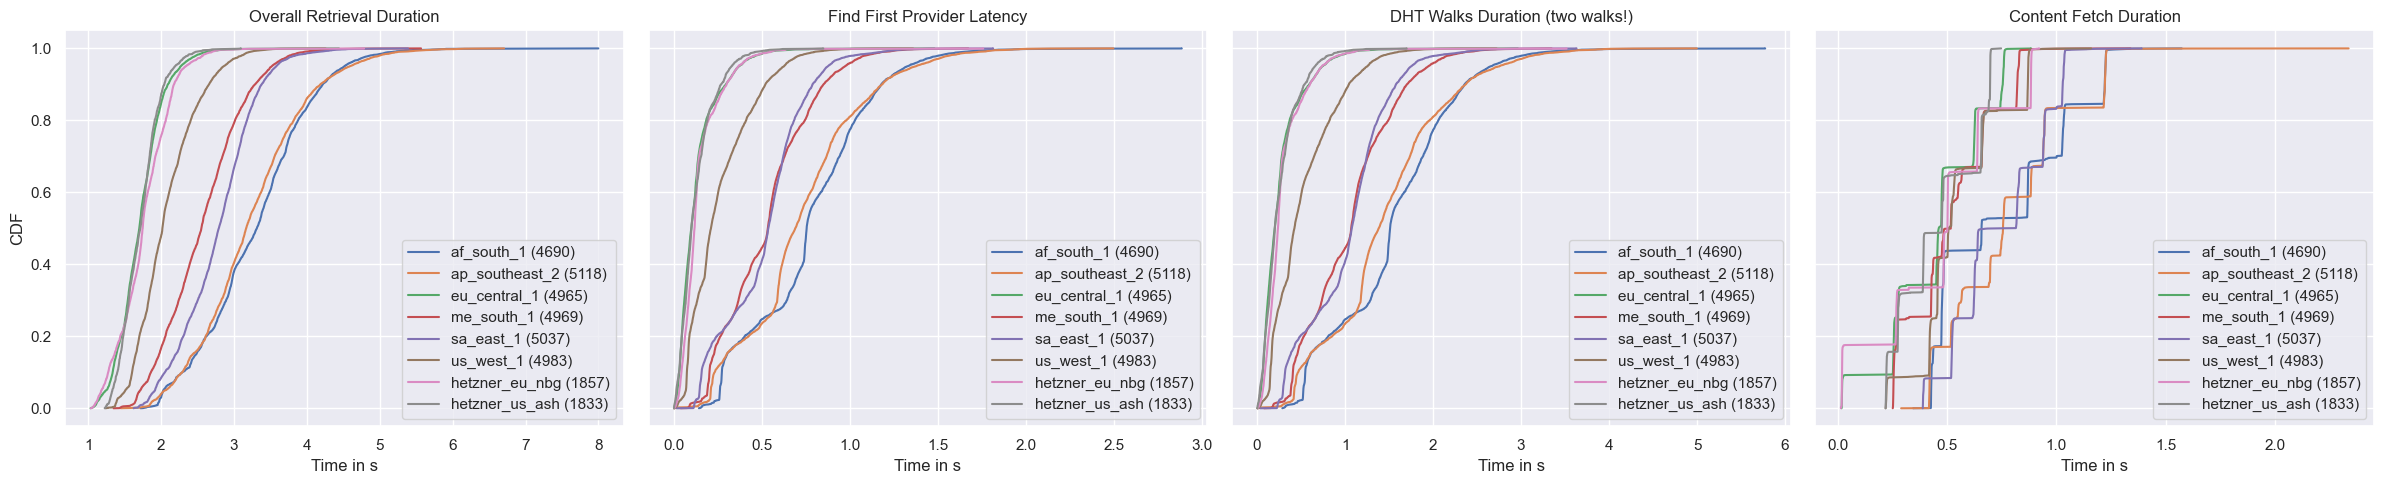

In [51]:
datasets = [
    overall_retrieval_duration_per_region,
    dht_ret_find_first_provider_per_region,
    dht_ret_walks_duration_per_region,
    content_fetch_duration_per_region
]

datasets_labels = ["Overall Retrieval Duration", "Find First Provider Latency", "DHT Walks Duration (two walks!)",
                   "Content Fetch Duration"]

fig, axes = plt.subplots(1, len(datasets), figsize=[24, 5], sharey=True)

regions = list(log_no_to_region.values())
regions = list(sorted(regions))
regions += ["hetzner_eu_nbg", "hetzner_us_ash"]

fig.axes[0].set_ylabel("CDF")
for i, dataset in enumerate(datasets):
    ax = fig.axes[i]
    for region in regions:
        data_cdf = cdf(pd.Series(data=dataset[region], name="time"))
        ax.set_title(datasets_labels[i])
        ax.plot(data_cdf["time"], data_cdf["cdf"], label=f"{region} ({len(data_cdf)})")
    ax.set_xlabel("Time in s")
    ax.legend()
# for i, region in enumerate(regions):
#     for j, dataset in enumerate(datasets):
#         data_by_region = dataset[percent_ignored]
#         idx = (i % len(percentages)) * len(datasets) + j
#         ax = fig.axes[idx]
#         for region in regions:
#             data = data_by_region[region]
#             data_df = pd.Series(data=data, name="time")
#             data_cdf = cdf(data_df)
#             ax.plot(data_cdf["time"], data_cdf["cdf"], label=region)
#             ax.set_title(f"{percent_labels[percent_ignored]}% of Hydras ignored | {datasets_labels[j]}")
#         if j == 2:
#             ax.set_xlim(xmax=2.5)
plt.tight_layout()